# 地理空間分析 v2

**目的**: 緯度・経度データを使った地理的パターンの分析

**このノートブックで行うこと**:
1. 主要都市からの距離計算
2. 距離とターゲットの関係分析
3. 地理的特徴量の生成示唆

## セットアップ

In [1]:
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# プロジェクトルートをパスに追加
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root / "04_src"))
os.chdir(project_root)

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# フォント設定
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
try:
    import japanize_matplotlib
    japanize_matplotlib.japanize()
except ImportError:
    plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meiryo', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# テスト済み関数のimport
from eda.location import (
    haversine_distance,
    calculate_distances_to_major_cities,
    MAJOR_CITIES
)

print("✓ セットアップ完了")

✓ セットアップ完了


## 1. データ読み込み

In [2]:
# データ読み込み（DataLoaderパターン）
from data.loader import DataLoader
from utils.config import load_config

data_config = load_config("data")
loader = DataLoader(data_config)
train = loader.load_train()

print(f"訓練データ: {train.shape}")

# lat/lon カラムの確認
if 'lat' in train.columns and 'lon' in train.columns:
    print(f"\n緯度・経度データ:")
    print(f"  lat範囲: {train['lat'].min():.6f} ~ {train['lat'].max():.6f}")
    print(f"  lon範囲: {train['lon'].min():.6f} ~ {train['lon'].max():.6f}")
    print(f"  欠損値: lat={train['lat'].null_count()}, lon={train['lon'].null_count()}")
else:
    print("\n警告: lat/lonカラムが見つかりません")

訓練データ: (363924, 149)

緯度・経度データ:
  lat範囲: 26.090097 ~ 43.856396
  lon範囲: 127.656334 ~ 144.444086
  欠損値: lat=0, lon=0


## 2. 主要都市の確認

In [3]:
# 定義されている主要都市を表示
print("[主要都市座標]")
for city_name, (lat, lon) in MAJOR_CITIES.items():
    print(f"  {city_name:10s}: ({lat:8.6f}, {lon:9.6f})")

[主要都市座標]
  東京駅       : (35.681236, 139.767125)
  新宿駅       : (35.689592, 139.700464)
  渋谷駅       : (35.658034, 139.701636)
  大阪駅       : (34.702485, 135.495951)
  名古屋駅      : (35.170915, 136.881537)
  福岡駅       : (33.589542, 130.420841)


## 3. 主要都市からの距離計算

In [4]:
# サンプルデータで距離計算をテスト（最初の1000件）
sample_train = train.head(1000).drop_nulls(subset=['lat', 'lon'])

# 各都市への距離を計算
distance_data = []

for row in sample_train.iter_rows(named=True):
    lat = row['lat']
    lon = row['lon']
    
    # 主要都市への距離を計算（テスト済み関数）
    distances = calculate_distances_to_major_cities(lat, lon)
    
    row_data = {'lat': lat, 'lon': lon}
    row_data.update({f'dist_{city}': dist for city, dist in distances.items()})
    
    # ターゲット変数も追加
    if 'money_room' in row:
        row_data['money_room'] = row['money_room']
    
    distance_data.append(row_data)

# DataFrameに変換
dist_df = pl.DataFrame(distance_data)

print("[距離データ - サンプル]")
print(dist_df.head())

[距離データ - サンプル]
shape: (5, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ lat       ┆ lon       ┆ dist_東京 ┆ dist_新宿 ┆ … ┆ dist_大阪 ┆ dist_名古 ┆ dist_福岡 ┆ money_ro │
│ ---       ┆ ---       ┆ 駅        ┆ 駅        ┆   ┆ 駅        ┆ 屋駅      ┆ 駅        ┆ om       │
│ f64       ┆ f64       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 35.047688 ┆ 136.63746 ┆ 292.38925 ┆ 286.74298 ┆ … ┆ 110.98246 ┆ 26.0894   ┆ 593.37547 ┆ 13980000 │
│           ┆ 7         ┆ 9         ┆           ┆   ┆           ┆           ┆ 9         ┆          │
│ 35.074625 ┆ 136.63993 ┆ 291.41851 ┆ 285.75004 ┆ … ┆ 112.24707 ┆ 24.443045 ┆ 594.32920 ┆ 24480000 │
│           ┆ 6         ┆ 6         ┆ 4         ┆   ┆ 6         ┆           ┆ 

## 4. 距離とターゲットの関係

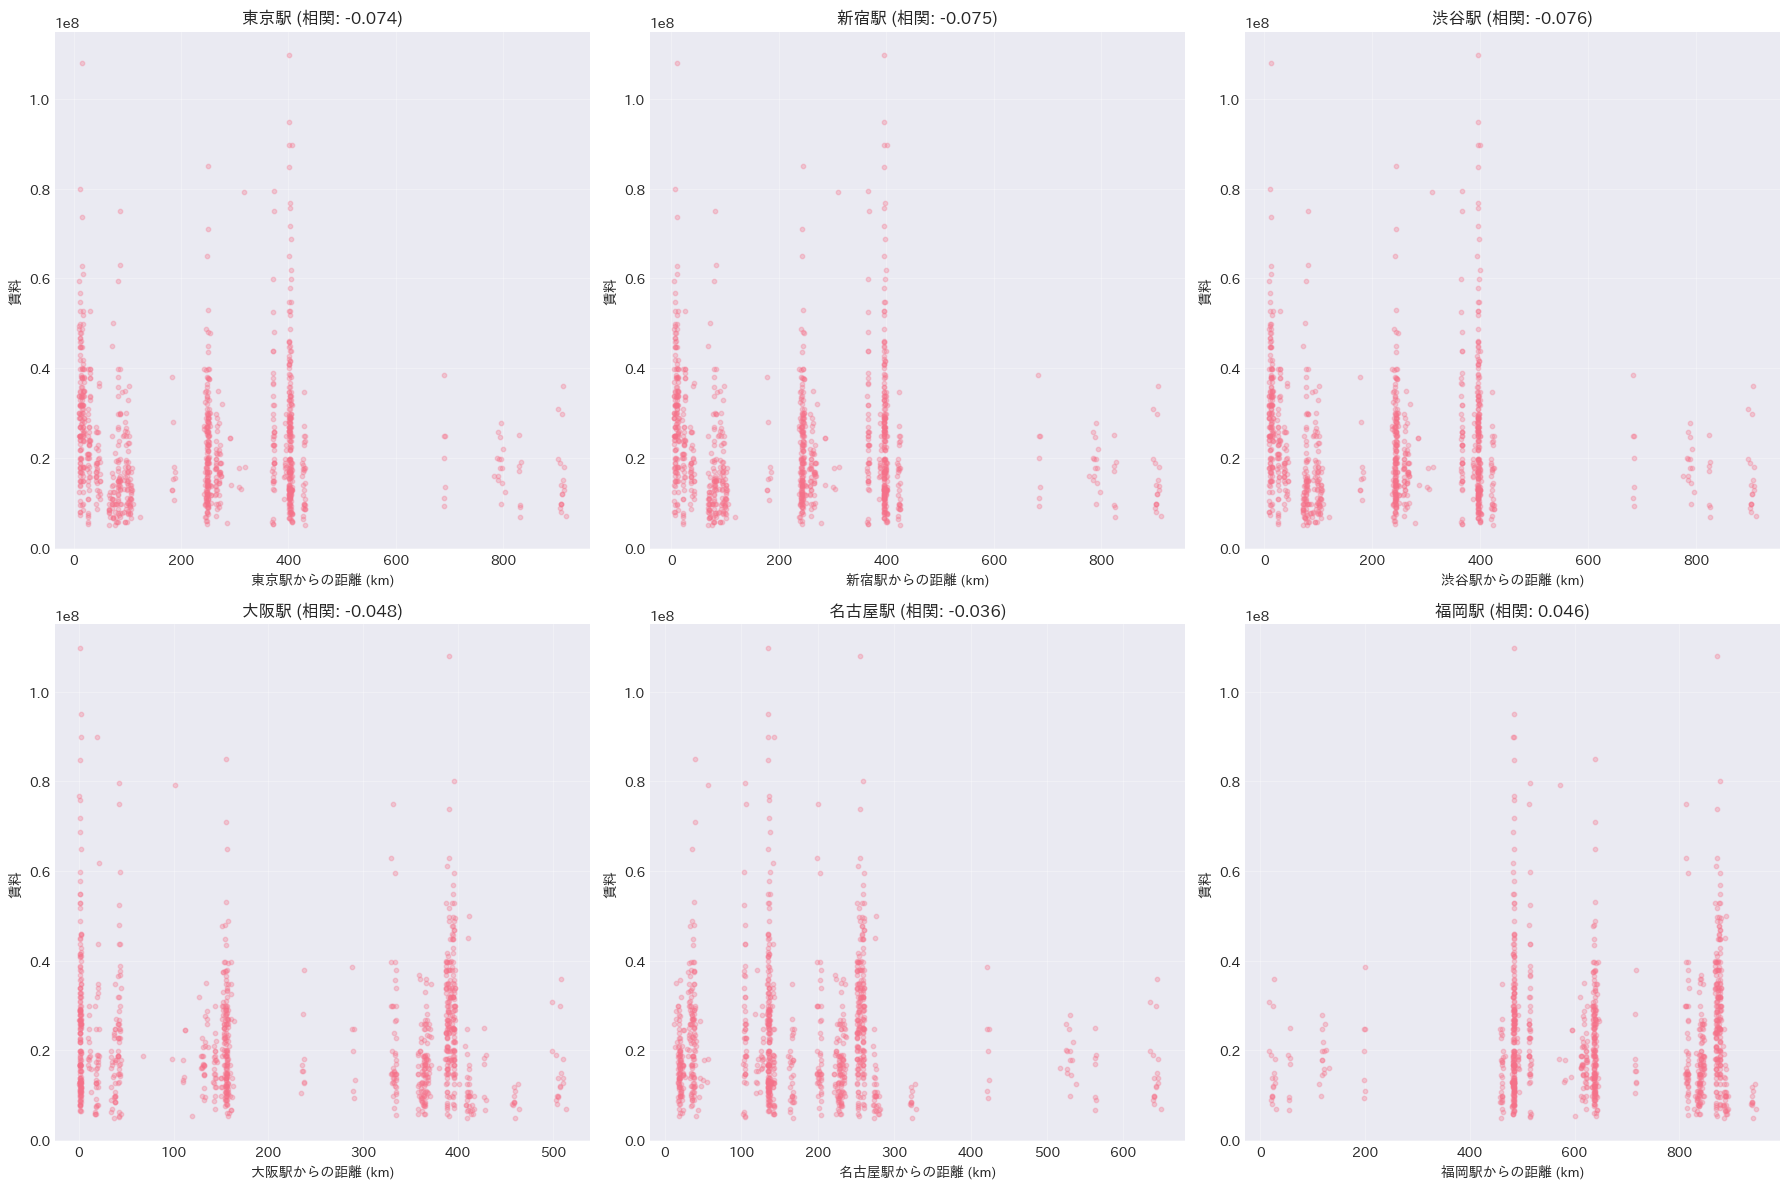

In [5]:
# 各都市への距離とターゲットの散布図
if 'money_room' in dist_df.columns:
    city_cols = [col for col in dist_df.columns if col.startswith('dist_')]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx, col in enumerate(city_cols):
        if idx >= 6:
            break
        
        ax = axes[idx]
        city_name = col.replace('dist_', '')
        
        # 散布図
        ax.scatter(
            dist_df[col],
            dist_df['money_room'],
            alpha=0.3,
            s=10
        )
        
        # 相関係数を計算
        valid_data = dist_df.select([col, 'money_room']).drop_nulls()
        if len(valid_data) > 1:
            corr = np.corrcoef(
                valid_data[col].to_numpy(),
                valid_data['money_room'].to_numpy()
            )[0, 1]
        else:
            corr = 0.0
        
        ax.set_xlabel(f'{city_name}からの距離 (km)')
        ax.set_ylabel('賃料')
        ax.set_title(f'{city_name} (相関: {corr:.3f})')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("ターゲット変数が見つかりません")

## 5. 距離ビン別の統計量

[東京駅からの距離ビン別統計（5km刻み）]
shape: (20, 4)
┌──────────┬───────┬────────────┬───────────┐
│ dist_bin ┆ count ┆ mean_price ┆ std_price │
│ ---      ┆ ---   ┆ ---        ┆ ---       │
│ f64      ┆ u32   ┆ f64        ┆ f64       │
╞══════════╪═══════╪════════════╪═══════════╡
│ 10.0     ┆ 85    ┆ 3.0180e7   ┆ 1.3668e7  │
│ 15.0     ┆ 68    ┆ 3.2771e7   ┆ 1.5431e7  │
│ 20.0     ┆ 1     ┆ 1.99e7     ┆ null      │
│ 25.0     ┆ 42    ┆ 2.1377e7   ┆ 9.0612e6  │
│ 30.0     ┆ 4     ┆ 4.2075e7   ┆ 7.2182e6  │
│ …        ┆ …     ┆ …          ┆ …         │
│ 100.0    ┆ 25    ┆ 1.59276e7  ┆ 7.7031e6  │
│ 105.0    ┆ 15    ┆ 1.1871e7   ┆ 3.2674e6  │
│ 110.0    ┆ 1     ┆ 9.8e6      ┆ null      │
│ 120.0    ┆ 1     ┆ 6.9e6      ┆ null      │
│ 180.0    ┆ 5     ┆ 2.14e7     ┆ 1.1209e7  │
└──────────┴───────┴────────────┴───────────┘


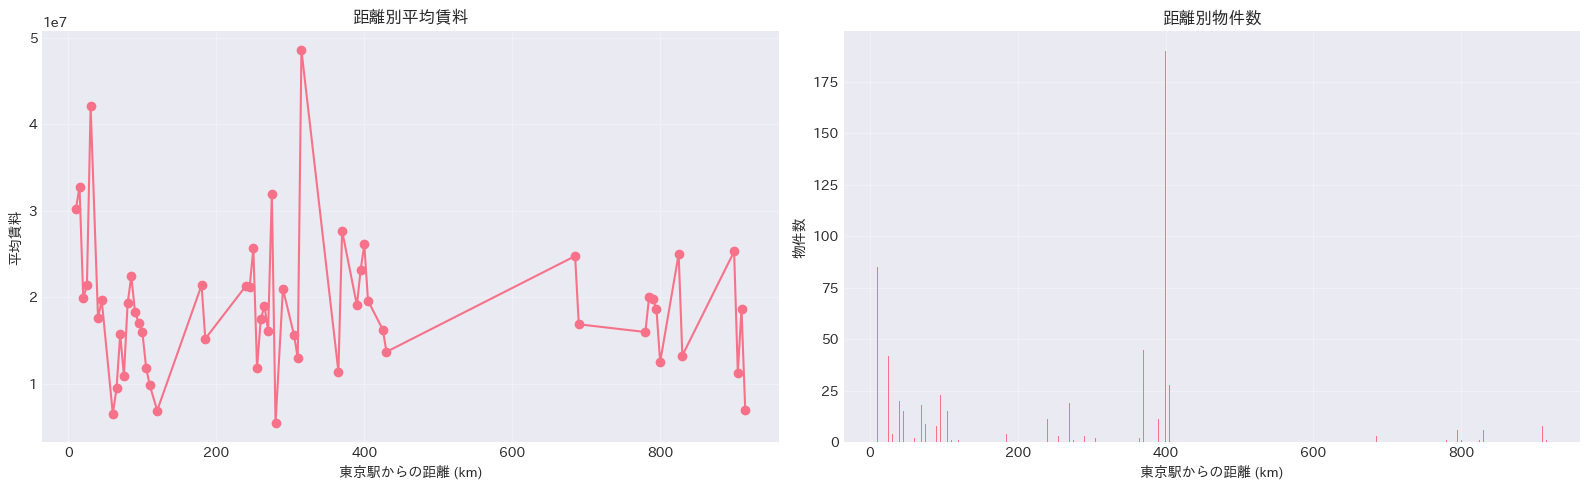

In [6]:
# 東京駅からの距離をビン分割して統計量を確認
if 'dist_東京駅' in dist_df.columns and 'money_room' in dist_df.columns:
    # 距離を5kmごとのビンに分割
    dist_df = dist_df.with_columns(
        (pl.col('dist_東京駅') // 5 * 5).alias('dist_bin')
    )
    
    # ビン別統計量
    bin_stats = dist_df.group_by('dist_bin').agg([
        pl.len().alias('count'),
        pl.col('money_room').mean().alias('mean_price'),
        pl.col('money_room').std().alias('std_price')
    ]).sort('dist_bin')
    
    print("[東京駅からの距離ビン別統計（5km刻み）]")
    print(bin_stats.head(20))
    
    # 可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # 平均賃料
    ax1.plot(bin_stats['dist_bin'], bin_stats['mean_price'], marker='o')
    ax1.set_xlabel('東京駅からの距離 (km)')
    ax1.set_ylabel('平均賃料')
    ax1.set_title('距離別平均賃料')
    ax1.grid(True, alpha=0.3)
    
    # 件数
    ax2.bar(bin_stats['dist_bin'], bin_stats['count'])
    ax2.set_xlabel('東京駅からの距離 (km)')
    ax2.set_ylabel('物件数')
    ax2.set_title('距離別物件数')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 6. まとめ

### 地理的パターン
- **主要都市との距離**: [パターンのメモ]
- **距離とターゲットの相関**: [メモ]
- **都市別の傾向**: [メモ]

### 特徴量エンジニアリング案
- [ ] 最寄り主要都市までの距離
- [ ] 複数都市への平均距離
- [ ] 都市中心部からの方角（東西南北）
- [ ] 距離ビンのカテゴリ化

### 次のステップ
- [ ] 特徴量エンジニアリングの実装
- [ ] モデリング準備